In [1]:
import pandas as pd
import numpy as np
import json
import os
import seaborn as sbn
import matplotlib.pyplot as plt
import seaborn as sns

#import bokeh.palettes

plt.rcParams['svg.fonttype'] = 'none'

sns.set_context("paper")
sns.set_style("white")

# Mutation data process rules

In [2]:
mut_df=pd.read_csv("../Data/Mutation_data/strain_mutation_table.tsv", sep="\t")
mut_df=mut_df.rename(columns={"Unnamed: 0":"mut_id"})

In [3]:
mut_df.head(3)

,mut_id,HMDA1-10,HMDA2-1,HMDA2-8,HMDA3-4,HMDA3-5,HMDA3-6,HMDA4-2,HMDA4-6,HMDA4-9,...,BUT9-7,BUT9-10,GLU1-1,GLU2-1,GLU3-1,GLU4-1,GLU5-1,GLU6-1,GLU7-1,GLU8-1
0,SNP-3816611-A,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,SNP-2694102-A,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,SNP-4257602-T,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
f = open("../Data/Mutation_data/Mutations_to_gene_names.json")
mut_to_genes=json.load(f)
data_list=list(mut_to_genes.items())
mut_to_genes=pd.DataFrame(data_list, columns=['mut','Gene'])

In [5]:
for i in mut_df.index:
    mut_df.loc[i,'mutation_type']=mut_df.loc[i,'mut_id'].split("-")[0]
    mut_df.loc[i,'start']=mut_df.loc[i,'mut_id'].split("-")[1]
    #mut_df.loc[i,'mutation_type']=''.join([str(item) for item in mut_df.loc[i,'mutation_type']])

In [6]:
#Drop MOB and DUP mutation information
mut_df=mut_df[(mut_df['mutation_type']!='DUP')]

In [7]:
mut_df.head()

,mut_id,HMDA1-10,HMDA2-1,HMDA2-8,HMDA3-4,HMDA3-5,HMDA3-6,HMDA4-2,HMDA4-6,HMDA4-9,...,GLU1-1,GLU2-1,GLU3-1,GLU4-1,GLU5-1,GLU6-1,GLU7-1,GLU8-1,mutation_type,start
0,SNP-3816611-A,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,SNP,3816611
1,SNP-2694102-A,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,SNP,2694102
2,SNP-4257602-T,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,SNP,4257602
3,SNP-962939-A,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,SNP,962939
4,SNP-4181786-T,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,SNP,4181786


In [8]:
for i in mut_df.index:
    mut_df.loc[i,'Gene']= mut_to_genes[mut_to_genes['mut']==mut_df.loc[i,'mut_id']].Gene.values
    if len( mut_df.loc[i,'Gene'])==0:
         mut_df.loc[i,'Gene']=""
    else:
        mut_df.loc[i,'Gene']=','.join(str(item) for item in mut_df.loc[i,'Gene'])
        mut_df.loc[i,'Gene']=mut_df.loc[i,'Gene'].replace("[","")
        mut_df.loc[i,'Gene']=mut_df.loc[i,'Gene'].replace("]","")
        mut_df.loc[i,'Gene']=mut_df.loc[i,'Gene'].replace("'","")

In [9]:
mut_df['start']=mut_df['start'].astype('int64')
mut_df=mut_df.sort_values(by="start")
mut_df=mut_df.reset_index(drop=True)

In [10]:
#Drop hypermutator

In [11]:
hypermutators_df=pd.read_csv("../Data/Mutation_data/hypermutators_list_glc.csv")

In [12]:
hypermutators_df.index.size

32

In [13]:
mut_df=mut_df.drop(columns=hypermutators_df['strain_code'])
mut_df=mut_df[mut_df.iloc[:,2:-3].sum(axis=1)!=0]

In [14]:
mut_df.head()

,mut_id,HMDA1-10,HMDA2-1,HMDA2-8,HMDA3-4,HMDA3-5,HMDA3-6,HMDA5-4,HMDA5-5,HMDA5-10,...,GLU1-1,GLU2-1,GLU3-1,GLU4-1,GLU6-1,GLU7-1,GLU8-1,mutation_type,start,Gene
0,SNP-2374-T,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,SNP,2374,thrA
11,SNP-20771-A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,SNP,20771,insA
42,SNP-64352-C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,SNP,64352,polB
55,SNP-82594-G,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,SNP,82594,leuA
58,DEL-83679-3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,DEL,83679,leuL


# Identifying frequently mutated operon

In [15]:
#Read gene_table containing operon (i.e., transcriotion unit) information from Ecocyc

In [16]:
gene_table = pd.read_csv("../Data/gene_info_GenBank.csv", index_col=0)  # Unique to this NB
gene_table.gene_name=gene_table.gene_name.str.replace('-','')
gene_table.start=gene_table.start.astype('int64')
gene_table.head()

,gene_name,accession,old_locus_tag,start,end,strand,gene_product,COG,uniprot,operon
locus_tag,,,,,,,,,,
b0001,thrL,NC_000913.3,NaN,190,255,+,thr operon leader peptide,No COG annotation,P0AD86,Op0
b0002,thrA,NC_000913.3,NaN,337,2799,+,fused aspartate kinase/homoserine dehydrogenase 1,Amino acid transport and metabolism,P00561,Op0
b0003,thrB,NC_000913.3,NaN,2801,3733,+,homoserine kinase,Nucleotide transport and metabolism,P00547,Op0
b0004,thrC,NC_000913.3,NaN,3734,5020,+,threonine synthase,Amino acid transport and metabolism,P00934,Op0
b0005,yaaX,NC_000913.3,NaN,5234,5530,+,DUF2502 domain-containing protein YaaX,Function unknown,P75616,Op1


#Manually added gene name

b1522 dgcF -> YneF
b0022 insA1 -> insA
b1917 tcyN -> yecC
b1918 -> yecS

b1920 -> fliY
b1934 newly added

b1956 ydeQ
yedS

b2092 gatC
b2352 -> gtrS


b3423 glpR



In [17]:
mut_df.head()

,mut_id,HMDA1-10,HMDA2-1,HMDA2-8,HMDA3-4,HMDA3-5,HMDA3-6,HMDA5-4,HMDA5-5,HMDA5-10,...,GLU1-1,GLU2-1,GLU3-1,GLU4-1,GLU6-1,GLU7-1,GLU8-1,mutation_type,start,Gene
0,SNP-2374-T,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,SNP,2374,thrA
11,SNP-20771-A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,SNP,20771,insA
42,SNP-64352-C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,SNP,64352,polB
55,SNP-82594-G,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,SNP,82594,leuA
58,DEL-83679-3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,DEL,83679,leuL


# Process deletions in multiple genes

In [18]:
#count gene numbers mutated by a single mutation event

for i in mut_df.index:
    mut_df.Gene = mut_df.Gene.str.replace(' ', '')
    mut_df.loc[i,'gene_num']=len(mut_df.loc[i,'Gene'].split(','))

In [19]:
gene_table.gene_name=gene_table.gene_name.str.replace('-','')

In [20]:
#split deletion of multiple genes into multiple rows
#Index for newly added rows will be "original index-1,2,3,...""

for i in mut_df[mut_df['gene_num']!=1].index:
    multiple_gene_names = mut_df.loc[i,'Gene'].split(',')

    temp1 = mut_df.loc[i]

    for j in range(0,len(multiple_gene_names)):
        temp1.Gene=multiple_gene_names[j]
        temp1.start=gene_table[gene_table['gene_name']==temp1.Gene].start.tolist()[0]
        temp1.name=str(mut_df.loc[i].name)+'-'+str(j+1)
        mut_df=mut_df.append(pd.Series(temp1))

    mut_df=mut_df.drop([i])

/var/folders/lb/2grw3fwd7pbf9hc08c9r8t4h0000gn/T/ipykernel_73872/2536655973.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp1.Gene=multiple_gene_names[j]
/var/folders/lb/2grw3fwd7pbf9hc08c9r8t4h0000gn/T/ipykernel_73872/2536655973.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp1.start=gene_table[gene_table['gene_name']==temp1.Gene].start.tolist()[0]
/var/folders/lb/2grw3fwd7pbf9hc08c9r8t4h0000gn/T/ipykernel_73872/2536655973.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mut_df=mut_df.append(pd.Series(temp1))

/var/folders/lb/2grw3fwd7pbf9hc08c9r8t4h0000gn/T/ipykernel_73872/2536655973.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mut_df=mut_df.append(pd.Series(temp1))
/var/folders/lb/2grw3fwd7pbf9hc08c9r8t4h0000gn/T/ipykernel_73872/2536655973.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mut_df=mut_df.append(pd.Series(temp1))
/var/folders/lb/2grw3fwd7pbf9hc08c9r8t4h0000gn/T/ipykernel_73872/2536655973.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mut_df=mut_df.append(pd.Series(temp1))
/var/folders/lb/2grw3fwd7pbf9hc08c9r8t4h0000gn/T/ipykernel_73872/2536655973.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mut_df=mut_

/var/folders/lb/2grw3fwd7pbf9hc08c9r8t4h0000gn/T/ipykernel_73872/2536655973.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mut_df=mut_df.append(pd.Series(temp1))
/var/folders/lb/2grw3fwd7pbf9hc08c9r8t4h0000gn/T/ipykernel_73872/2536655973.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mut_df=mut_df.append(pd.Series(temp1))
/var/folders/lb/2grw3fwd7pbf9hc08c9r8t4h0000gn/T/ipykernel_73872/2536655973.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mut_df=mut_df.append(pd.Series(temp1))
/var/folders/lb/2grw3fwd7pbf9hc08c9r8t4h0000gn/T/ipykernel_73872/2536655973.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mut_df=mut_

/var/folders/lb/2grw3fwd7pbf9hc08c9r8t4h0000gn/T/ipykernel_73872/2536655973.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mut_df=mut_df.append(pd.Series(temp1))
/var/folders/lb/2grw3fwd7pbf9hc08c9r8t4h0000gn/T/ipykernel_73872/2536655973.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mut_df=mut_df.append(pd.Series(temp1))
/var/folders/lb/2grw3fwd7pbf9hc08c9r8t4h0000gn/T/ipykernel_73872/2536655973.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mut_df=mut_df.append(pd.Series(temp1))
/var/folders/lb/2grw3fwd7pbf9hc08c9r8t4h0000gn/T/ipykernel_73872/2536655973.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mut_df=mut_

In [21]:
#Some gene names are duplicated in a deleted gene list causing a duplication of rows. e.g., crl
mut_df[mut_df.duplicated()]

,mut_id,HMDA1-10,HMDA2-1,HMDA2-8,HMDA3-4,HMDA3-5,HMDA3-6,HMDA5-4,HMDA5-5,HMDA5-10,...,GLU2-1,GLU3-1,GLU4-1,GLU6-1,GLU7-1,GLU8-1,mutation_type,start,Gene,gene_num
164-5,DEL-255591-18364,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,DEL,257829,crl,27.0
164-26,DEL-255591-18364,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,DEL,270278,insN,27.0
169-20,DEL-260217-13738,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,DEL,270278,insN,21.0
1567-20,DEL-1995819-40006,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,DEL,2011223,yedN,50.0
1567-21,DEL-1995819-40006,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,DEL,2011223,yedN,50.0
1567-50,DEL-1995819-40006,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,DEL,2035835,yedS,50.0
2150-7,DEL-2801966-11843,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,DEL,2808316,ygaY,12.0
2892-2,DEL-3815859-82,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,DEL,3815863,rph,2.0


In [22]:
mut_df=mut_df.drop_duplicates()

In [23]:
#Gene number information is no longer needed
mut_df=mut_df.drop(columns=['gene_num'])

In [24]:
mut_df=mut_df.drop(index=(mut_df[mut_df.Gene==''].index))

In [25]:
#Sort the mutation table by "start" and reindex
mut_df=mut_df.sort_values(by=['start'])
mut_df=mut_df.reset_index(drop=True)

In [26]:
gene_list=mut_df['Gene'].unique().tolist()

In [27]:
#total mutated gene number
len(gene_list)

386

# Create a new DataFrame for mutation frequency information

In [28]:
# Unique_df contains information about mutation frequency only for a given gene

In [29]:
unique_df=pd.DataFrame(columns=mut_df.columns)

In [30]:
#sum mutation frequencies if occured in the same gene

In [31]:
for i in gene_list:
    subset_df= mut_df[mut_df.Gene==i]
    unique_df.loc[i]=subset_df.sum(axis=0)

In [32]:
drop_col={'mut_id','mutation_type','start','Gene',
}

unique_df=unique_df.drop(columns=drop_col)

In [33]:
unique_df

,HMDA1-10,HMDA2-1,HMDA2-8,HMDA3-4,HMDA3-5,HMDA3-6,HMDA5-4,HMDA5-5,HMDA5-10,HMDA7-1,...,BUT7-9,BUT9-7,BUT9-10,GLU1-1,GLU2-1,GLU3-1,GLU4-1,GLU6-1,GLU7-1,GLU8-1
thrA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
insA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
polB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
leuA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
leuL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lgoR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
yjjQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rsmC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
nadR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
unique_df.to_csv("./unique_df_noNaCl.tsv", sep="\t")

In [35]:
# Leave only one isolate per each endpoint population

In [36]:
header_list=['compound_n','ALE','Isolate','Replicate','code']
mapping = pd.read_csv("../Data/Mutation_data/Variant_calls/mapping.csv", names=header_list)

#NaCl
#mapping = pd.read_csv("../Data/Mutation_data/Variant_calls/mapping_NaCl.csv", names=header_list)

In [37]:
compound_dict={  1: "BUT",
        2: "GLUT",
        3: "COUM",
        4:"NACL",
        5: "HMDA",
        6: "PUTR",
        7: "ADIP",
        8: "IBUA",
        9: "HEXA",
        10: "23BD",
        11: "12PD",
        12: "OCTA",
        13: "GLU"
     }

In [38]:
mapping['compound']=mapping.compound_n.map(compound_dict)

In [39]:
for i in mapping.index:
    mapping.loc[i,'temp']=mapping.loc[i,'compound']+'_'+str(mapping.loc[i,'ALE'])

In [40]:
condition = mapping[mapping['code'].isin(unique_df.columns)].reset_index(drop=True)

In [41]:
condition

,compound_n,ALE,Isolate,Replicate,code,compound,temp
0,1,1,1,1,BUT1-2,BUT,BUT_1
1,1,1,2,1,BUT1-3,BUT,BUT_1
2,1,1,3,1,BUT1-5,BUT,BUT_1
3,1,2,1,1,BUT2-9,BUT,BUT_2
4,1,3,1,1,BUT3-3,BUT,BUT_3
...,...,...,...,...,...,...,...
195,13,5,1,1,GLU3-1,GLU,GLU_5
196,13,6,1,1,GLU4-1,GLU,GLU_6
197,13,8,1,1,GLU6-1,GLU,GLU_8
198,13,9,1,1,GLU7-1,GLU,GLU_9


In [42]:
# Remove mutations detected because of contaminated reads

#unique_df=unique_df.drop(['rrlH']) #reads from Pseudomonas aeruginosa, co-sequenced together

In [43]:
# leave only one isolate per flask. This codes leave all mutation information from isolates from the same population

In [44]:
for i in condition['temp'].unique():
    if condition[condition.temp==i].index.size > 1:
        replicate_temp=condition[condition.temp==i]
        
        k=1
        while k < replicate_temp.index.size:
                unique_df[replicate_temp.loc[replicate_temp.index[0],'code']]=unique_df[replicate_temp.loc[replicate_temp.index[0],'code']]+unique_df[replicate_temp.loc[replicate_temp.index[0]+k,'code']]
                unique_df=unique_df.drop(columns={replicate_temp.loc[replicate_temp.index[0]+k,'code']})
                k=k+1

In [45]:
unique_df

,HMDA1-10,HMDA2-1,HMDA3-4,HMDA5-4,HMDA7-1,HMDA8-5,PUTR2-4,PUTR3-1,PUTR4-3,PUTR5-1,...,BUT6-1,BUT7-6,BUT9-7,GLU1-1,GLU2-1,GLU3-1,GLU4-1,GLU6-1,GLU7-1,GLU8-1
thrA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
insA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
polB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
leuA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
leuL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lgoR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
yjjQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rsmC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
nadR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
unique_df_cog = pd.DataFrame(index=unique_df.index)


In [47]:
for i in unique_df_cog.index:
    unique_df_cog.loc[i,'new_name']=i

In [48]:
#For genes having inconsistent names

gene_name_lib = pd.read_csv("../Data/gene_name_consistency.dat", sep='\t')
for i in unique_df_cog[~unique_df_cog.index.isin(gene_table.gene_name)].index:
    unique_df_cog.loc[i,'new_name']=gene_table.loc[gene_name_lib[gene_name_lib.Orf=='yliE']['Alternative name'].values[0].split(',')[0],'gene_name']


# COG analysis but it will not be used

In [ ]:
for i in unique_df_cog.index:
    unique_df_cog.loc[i,'cog']=gene_table[gene_table.gene_name==unique_df_cog.loc[i,'new_name']].COG.values[0]

In [ ]:
COG = pd.DataFrame(unique_df_cog.cog.value_counts())

In [ ]:
COG_others_sum=COG[COG.cog<10].sum().values[0].astype('int64')

In [ ]:
COG_low = COG[COG.cog<10].index
COG=COG.drop(index=COG_low)
COG.loc['Others','cog']=COG_others_sum

In [ ]:
fig1, ax1 = plt.subplots()
ax1.pie(COG.cog, labels=COG.index, #autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
COG=COG.sort_values(by='cog')

In [ ]:
ax =COG.cog.plot.barh()

# Merge if mutated genes are in the same TU - skipped

In [ ]:
#In the gene info table, some operon information is missing. If missing, put "unknown"

In [ ]:
k=1
for i in gene_table[gene_table.operon.isna()].index:
    gene_table.loc[i, 'operon']='unknown'+str(k)
    k=k+1

In [ ]:
#Add operon information to unique_df

k=0
for i in unique_df.index:
    if gene_table[gene_table.gene_name==i].index.size > 0:
        unique_df.loc[i,'operon']=gene_table[gene_table.gene_name==i].iat[0,9]
    else:
        unique_df.loc[i,'operon']='temp'+str(k)
        k=k+1

In [ ]:
# Find genes in the same operon, sum counts and replace a gene name to a region name

for i in unique_df.operon.unique(): 
    subset_df= unique_df[unique_df.operon==i]
    unique_df.loc[subset_df.index[0]]=subset_df.sum(axis=0)
    j=1 
    while j < subset_df.index.size:
        if j == 1:
            unique_df=unique_df.rename(index={subset_df.index[0]: subset_df.index[0]+'-'+subset_df.index[j]})
        else:
            unique_df=unique_df.rename(index={subset_df.index[0]+'-'+subset_df.index[j-1]: subset_df.index[0]+'-'+subset_df.index[j]})
        unique_df=unique_df.drop(index=[subset_df.index[j]])
        j=j+1

In [ ]:
unique_df=unique_df.drop(columns='operon')

# Reset all counts to 1
this is to increase a count by 1 even if there were multiple mutations in a gene.

In [49]:
unique_df_1=unique_df.copy()

for i in unique_df_1.columns:
    for j in unique_df_1.index:
        if (unique_df_1.loc[j,i]>0.5):
            unique_df_1.loc[j,i]=1

# Heatmap

In [50]:
#Rename unique_df_1 to mut_table
mut_table=unique_df_1.copy()

In [51]:
#show only genes mutated more than three times

In [52]:
count_sum=pd.DataFrame(mut_table.sum(axis=1))

In [53]:
mut_table['count_sum']=count_sum

In [54]:
table_to_show = mut_table[mut_table['count_sum']>4].drop(columns='count_sum')

In [55]:
#table_to_show=table_to_show.drop(index={'oppA'})

In [56]:
table_to_show

,HMDA1-10,HMDA2-1,HMDA3-4,HMDA5-4,HMDA7-1,HMDA8-5,PUTR2-4,PUTR3-1,PUTR4-3,PUTR5-1,...,BUT6-1,BUT7-6,BUT9-7,GLU1-1,GLU2-1,GLU3-1,GLU4-1,GLU6-1,GLU7-1,GLU8-1
nagC,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
nagA,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ybjL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rpsA,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
hns,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,1,1,1,0
rnb,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sapB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
marC,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
rnt,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pykF,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [57]:
table_to_show

,HMDA1-10,HMDA2-1,HMDA3-4,HMDA5-4,HMDA7-1,HMDA8-5,PUTR2-4,PUTR3-1,PUTR4-3,PUTR5-1,...,BUT6-1,BUT7-6,BUT9-7,GLU1-1,GLU2-1,GLU3-1,GLU4-1,GLU6-1,GLU7-1,GLU8-1
nagC,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
nagA,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ybjL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rpsA,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
hns,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,1,1,1,0
rnb,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sapB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
marC,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
rnt,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pykF,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [58]:
# Parsing sample names again

In [59]:
condition2 = mapping[mapping['code'].isin(table_to_show.columns)].reset_index(drop=True)

In [60]:
condition2

,compound_n,ALE,Isolate,Replicate,code,compound,temp
0,1,1,1,1,BUT1-2,BUT,BUT_1
1,1,2,1,1,BUT2-9,BUT,BUT_2
2,1,3,1,1,BUT3-3,BUT,BUT_3
3,1,4,1,1,BUT4-4,BUT,BUT_4
4,1,5,1,1,BUT5-2,BUT,BUT_5
...,...,...,...,...,...,...,...
76,13,5,1,1,GLU3-1,GLU,GLU_5
77,13,6,1,1,GLU4-1,GLU,GLU_6
78,13,8,1,1,GLU6-1,GLU,GLU_8
79,13,9,1,1,GLU7-1,GLU,GLU_9


In [61]:
# Group mutations

In [62]:
condition.compound.unique()

array(['BUT', 'GLUT', 'COUM', 'HMDA', 'PUTR', 'ADIP', 'IBUA', 'HEXA',
       '23BD', '12PD', 'OCTA', 'GLU'], dtype=object)

In [63]:
#In the order of Osmotic pressure

condition_osmotic=['12PD', '23BD','PUTR',  'GLUT', 'ADIP', 'HMDA', 'BUT','IBUA', 'COUM','OCTA',  'HEXA', 
       'GLUT', 'GLU']

chem_mut_table=pd.DataFrame()

for i in condition_osmotic:
    chem_mut_table[i]=table_to_show[condition2[condition2.compound==i].code].sum(axis=1)

In [64]:
chem_mut_table.to_csv("./mutation_frequency.csv")

In [65]:
print("A total of ",chem_mut_table.index.size, " regions were commonly mutated.")

A total of  35  regions were commonly mutated.


In [66]:
# Show heatmap with ratios
chem_mut_table_ratio = pd.DataFrame()

In [67]:
for chem in chem_mut_table.columns:
    chem_mut_table_ratio[chem] = chem_mut_table[chem]/int(condition[condition['compound']==chem].compound.value_counts())

In [68]:
col_order = ['12PD', '23BD','GLUT', 'ADIP',  'PUTR', 'HMDA', 'IBUA', 'COUM', 'BUT',
       'OCTA', 'HEXA', 'GLU']

In [69]:
# The order given is what ultimately ends up in the figure
chem_mut_table_ratio.columns
chem_mut_table_ratio = chem_mut_table_ratio[col_order]

In [70]:
chem_mut_table_ratio.head(2)

,12PD,23BD,GLUT,ADIP,PUTR,HMDA,IBUA,COUM,BUT,OCTA,HEXA,GLU
nagC,0.0,0.0,0.166667,0.111111,0.05,0.200000,0.0,0.0,0.0,0.0,0.0,0.0
nagA,0.0,0.0,0.125000,0.055556,0.00,0.066667,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
#Generate a df for mutation event number
mut_feat_sum_df = chem_mut_table.copy()
mut_feat_sum_df = mut_feat_sum_df.astype(int)
mut_feat_sum_df['sum'] = mut_feat_sum_df.sum(axis=1)
mut_feat_sum_df = mut_feat_sum_df[['sum']]

In [72]:
mut_feat_sum_df.head()

,sum
nagC,10
nagA,5
ybjL,5
rpsA,6
hns,11


In [73]:
palette = sns.color_palette(n_colors=12)
col_col = {
    '12PD':palette[0], #diols
    '23BD':palette[0],
    'HMDA':palette[1], #diamines
    'PUTR':palette[1],
    'GLUT':palette[2],
    'ADIP':palette[2],
    'HEXA':palette[3],
    'OCTA':palette[3],
    'COUM':palette[4],
    'IBUA':palette[4],
    'BUT':palette[4],
    'GLU':palette[6]
}
col_col=pd.Series(col_col)
col_col=col_col.reindex(col_order)

In [74]:
final_conc = {
    '12PD':1.09081351,
    '23BD':0.876599239,
    'HMDA':0.653988469,
    'PUTR':0.862166761,
    'GLUT':1.078564941,
    'ADIP':1.026413029,
    'HEXA':0.129132231,
    'OCTA':0.138686638,
    'COUM':0.243664717,
    'IBUA':0.286993457,
    'BUT':0.218623482,
    'GLU':0
}
final_conc=pd.DataFrame(pd.Series(final_conc))
final_conc=final_conc.rename(columns={0:'conc'})

In [75]:
from matplotlib.colors import LogNorm


posx and posy should be finite values


Text(0.4, 0.9, 'Common mutations identified in evolved isolates')

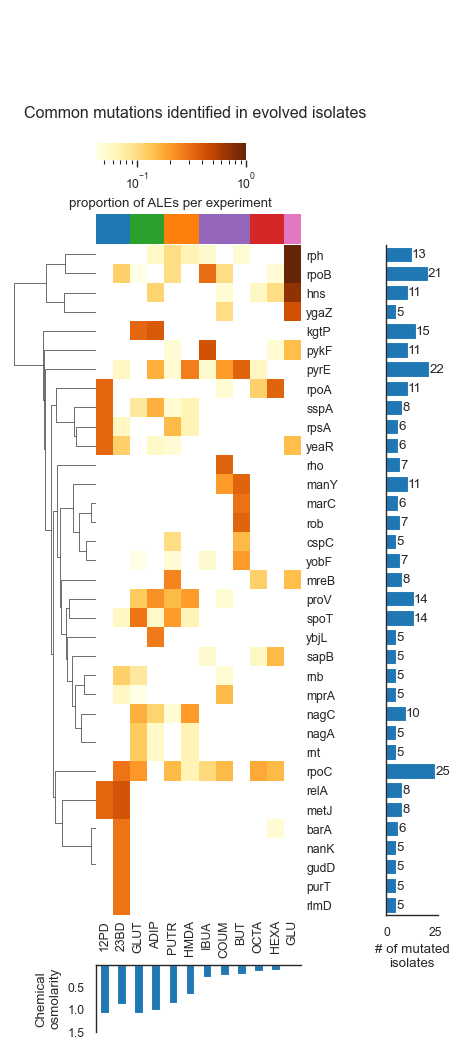

In [76]:
plt.rcParams["figure.dpi"] = 100
from mpl_toolkits.axes_grid1 import make_axes_locatable

cm = sns.clustermap(
    chem_mut_table_ratio[col_order],
    cmap="YlOrBr",
    col_cluster=False,
    row_cluster=True,

        figsize=(5, 11),
    cbar_kws={'label': 'proportion of ALEs per experiment', 'orientation':'horizontal'},
    cbar_pos=(0.2, 0.85, 0.3, 0.015),
    col_colors=[col_col],
  #  row_colors=temp.cog_color,

#    dendrogram_ratio=0.1
    norm=LogNorm()
)
cm.ax_heatmap.tick_params(axis='both', which='both', length=0)


barplot_padding = 0.85
osmo_barplot_padding = 0.5

heatmap_space = make_axes_locatable(cm.ax_heatmap)
mut_cnt_ax = heatmap_space.append_axes("right", size="25%", pad=barplot_padding)
col_colors_space = make_axes_locatable(cm.ax_col_colors)
nax_col_clrs = col_colors_space.new_horizontal(size="25%", pad=barplot_padding)

osmolarity_ax = heatmap_space.append_axes("bottom", size="10%", pad=osmo_barplot_padding)
row_dendo_space = make_axes_locatable(cm.ax_row_dendrogram)
# nax_osmolarity = row_dendo_space.new_vertical(size="10%", pad=osmo_barplot_padding)

# pack_start describes on what end the dendogram padding is applied
nay = row_dendo_space.new_vertical(size="10%", pad=osmo_barplot_padding, pack_start=True)  

# Sort the values for the bar plot to have the same order as clusters
cm_y_tick_order = [t.get_text() for t in np.array(cm.ax_heatmap.get_yticklabels())]
mut_feat_sum_df = mut_feat_sum_df.reindex(cm_y_tick_order)
ax = mut_feat_sum_df.plot.barh(rot=0, stacked=True, ax=mut_cnt_ax, width=0.8)
ax.bar_label(ax.containers[0])
mut_cnt_ax.spines['top'].set_visible(False)
mut_cnt_ax.spines['right'].set_visible(False)
mut_cnt_ax.set_ylim(-0.5,len(chem_mut_table_ratio.index)-0.5)  # needed to align bar-plots with clustermap residues
mut_cnt_ax.set_yticklabels([])
mut_cnt_ax.invert_yaxis()
mut_cnt_ax.set_xlabel("# of mutated\nisolates")
mut_cnt_ax.get_legend().remove()



#Add one more bar 
cm_x_tick_order = [t.get_text() for t in np.array(cm.ax_heatmap.get_xticklabels())]
final_conc=final_conc.reindex(cm_x_tick_order)
ax2 = final_conc.plot.bar(rot=0, stacked=True, ax=osmolarity_ax)
#osmolarity_ax.bar_label(osmolarity_ax.containers[0], rotation=90)

osmolarity_ax.invert_yaxis()
osmolarity_ax.spines['bottom'].set_visible(False)
osmolarity_ax.spines['right'].set_visible(False)
osmolarity_ax.set_ylabel("Chemical\nosmolarity")
osmolarity_ax.set_yticks([0.5, 1, 1.5])
osmolarity_ax.get_legend().remove()
osmolarity_ax.xaxis.set_visible(False)

col=cm.ax_col_dendrogram.get_position()
#cm.ax_col_dendrogram.set_position([col.x0, col.y0, col.width*0.75, col.height*0.2])

col2=cm.ax_row_dendrogram.get_position()

#cm.ax_row_dendrogram.set_position([col2.x0, 0.17, col2.x1, col2.y1])


cm.fig.suptitle("Common mutations identified in evolved isolates",
                y=0.9,
                x=0.4
               )

In [78]:
cm.savefig('../Plots/Figure 2_cluster.svg')

In [79]:
chem_mut_table_ratio.index

Index(['nagC', 'nagA', 'ybjL', 'rpsA', 'hns', 'rnb', 'sapB', 'marC', 'rnt',
       'pykF', 'yeaR', 'manY', 'cspC', 'yobF', 'purT', 'kgtP', 'proV', 'ygaZ',
       'mprA', 'relA', 'rlmD', 'barA', 'gudD', 'nanK', 'sspA', 'mreB', 'rpoA',
       'pyrE', 'rph', 'spoT', 'rho', 'metJ', 'rpoB', 'rpoC', 'rob'],
      dtype='object')

In [ ]:
#Check whether general or chemical-specific tolerance genetic region
chem_mut_table_ratio_1=chem_mut_table_ratio.copy()
chem_mut_table_ratio_1[chem_mut_table_ratio_1!=0]=1

In [ ]:
noglu_group = chem_mut_table_ratio_1.copy()

In [ ]:
noglu_group['sum'] = noglu_group.sum(axis=1)

In [ ]:
for i in noglu_group.index:
    if noglu_group.loc[i,'sum']>2:
        noglu_group.loc[i,'mut_type']='general'
    elif noglu_group.loc[i,'sum']==2: #check whether they are in the same group
        chem1 = noglu_group.T[noglu_group.loc[i]==1].index.to_list()[0]
        chem2 = noglu_group.T[noglu_group.loc[i]==1].index.to_list()[1]
        if col_col.get(chem1)==col_col.get(chem2):
            if col_col.get(chem1)==col_col.get('BUT'):  #chem belongs to "others""
                noglu_group.loc[i,'mut_type']='general'
            else:
                noglu_group.loc[i,'mut_type']='chem-specific'
        else:
            noglu_group.loc[i,'mut_type']='general'
    elif noglu_group.loc[i,'sum']==1:
        noglu_group.loc[i,'mut_type']='chem-specific'
    
    #regardless of above categorization, if a mutation was observed in the GLU condition, set it to be culturing condition
    if noglu_group.loc[i,'GLU']!=0:
        noglu_group.loc[i,'mut_type']='culturing-condition specific'

In [ ]:
noglu_group

In [ ]:
noglu_group = noglu_group.drop(index=noglu_group[noglu_group.GLU!=0].index, columns="GLU")
noglu_group=noglu_group.sort_values(by='sum', ascending =False)
noglu_group

In [ ]:
Mutation_dict = {
    'sapF-sapA':'Transport',
    'proV-proX':'Transport',
    'spoT':'Stress signaling',
    'rpoA-rpsD':'TX/TL machineries',
    'sspA':'Stress signaling',
    'mrdB-rsfS':'Membrane components',
    'nagC-nagA':'Membrane components',
    'rpsA':'TX/TL machineries',
    'tufA-rpsL':'TX/TL machineries',
    'pnp-nusA':'TX/TL machineries',
    'cspC-yobF':'Stress signaling',
    'rnt-lhr':'TX/TL machineries',
    'rnb':'TX/TL machineries',
    'mprA-emrB':'Transport',
    'pstB-pstS':'Transport',
    'metJ':'Metabolism',
    'relA':'Stress signaling',
    'barA':'Stress signaling',
    'kgtP':'Transport',
    'manY':'Transport',
    'gudD':'Metabolism',
    'nanK':'Membrane components',
    'rlmD':'TX/TL machineries',
    'purT':'Metabolism',
    'marC':'Membrane components',
    'rho':'TX/TL machineries',
    'ybjL':'Transport',
    'rob':'Stress signaling',
'insN-insI1':'No information',
'atpI':'Metabolism',
'gtrS':'Membrane components',
'yedP':'Metabolism',
'rpoS':'Stress signaling',
'ptsP':'Transport',
    'nadR':'Metabolism',
        'mdtK':'Transport'


}

In [ ]:
mut_feat_sum_df[mut_feat_sum_df['sum']==4]

In [ ]:
noglu_group['function']=noglu_group.index.map(Mutation_dict)

In [ ]:
noglu_group

In [ ]:
noglu_group['function'].unique()

In [ ]:
print("General tolerance regions: ",noglu_group[noglu_group.mut_type=='general'].index.size," Chemical specific regions: ",noglu_group[noglu_group.mut_type=='chem-specific'].index.size)

In [ ]:
ax=noglu_group[noglu_group.mut_type=='general'].function.value_counts().plot(kind='pie', autopct='%1.1f%%')
ax.get_figure().savefig("./genera_pie.svg")

In [ ]:
ax=noglu_group[noglu_group.mut_type=='chem-specific'].function.value_counts().plot(kind='pie', autopct='%1.1f%%')
ax.get_figure().savefig("./specific_pie.svg")

In [ ]:
mut_table.loc[noglu_group[noglu_group.mut_type=='general'].index].sort_values(by='count_sum', ascending=False).count_sum

In [ ]:
mut_table.loc[noglu_group[noglu_group.mut_type=='chem-specific'].index].sort_values(by='count_sum', ascending=False).count_sum

In [ ]:
temp = noglu_group[noglu_group.mut_type=='general'].sort_values(by='sum', ascending=False)

In [ ]:
temp

In [ ]:
mut_table.loc[noglu_group[noglu_group.mut_type=='general'].index].boxplot('count_sum')

In [ ]:
noglu_group[noglu_group.mut_type=='general']['sum'].mean()

In [ ]:
mut_table.loc[noglu_group[noglu_group.mut_type=='general'].index]['count_sum'].mean()

In [ ]:
noglu_group[noglu_group.mut_type=='chem-specific'].sort_values(by='sum', ascending=False)

In [ ]:
noglu_group[noglu_group.mut_type=='chem-specific'].sort_values(by='sum', ascending=False)

In [ ]:
mut_table.loc[noglu_group[noglu_group.mut_type=='chem-specific'].index].boxplot('count_sum')

In [ ]:
noglu_group[noglu_group.function=="Transport"]